In [74]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 10

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)


depot_longitude       =  -79.383292
depot_latitude        =  43.652224

demand = np.random.randint(1, 11, number_cities-1)
demand = np.insert(demand,0,0)
print(demand)

longitude = np.random.normal(depot_longitude, 0.008, number_cities)
latitude  = np.random.normal(depot_latitude, 0.008, number_cities)

coords  =  []
k       =  0
for citie in range(len(cities)):
    coords.append([abs(round(longitude[k]*100000)), abs(round(latitude[k]*100000))])
    k += 1

print(coords)
df      = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
#df     = pd.DataFrame({"longitude":longitude,
#                       "latitude":latitude},  index=cities)

df_map = pd.DataFrame({"longitude":longitude,
                       "latitude":latitude,
                       "demand":demand},  index=cities)
print(df)
print("-------------------------------")
print(df_map)

[ 0  3  7  3  5 10  5  4  5  9]
[[7939159, 4366341], [7937774, 4366282], [7937965, 4365779], [7938553, 4365027], [7936801, 4365405], [7937345, 4364623], [7937495, 4365567], [7939028, 4363781], [7938714, 4365134], [7937070, 4365867]]
     xcord    ycord
A  7939159  4366341
B  7937774  4366282
C  7937965  4365779
D  7938553  4365027
E  7936801  4365405
F  7937345  4364623
G  7937495  4365567
H  7939028  4363781
I  7938714  4365134
J  7937070  4365867
-------------------------------
   longitude   latitude  demand
A -79.391593  43.663413       0
B -79.377739  43.662822       3
C -79.379650  43.657793       7
D -79.385528  43.650275       3
E -79.368011  43.654053       5
F -79.373450  43.646227      10
G -79.374946  43.655667       5
H -79.390283  43.637810       4
I -79.387136  43.651337       5
J -79.370699  43.658671       9


In [72]:
x, y = coords.T                                   # We define that the first value of coords is X and the second is Y
plt.plot(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:],y[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

AttributeError: 'list' object has no attribute 'T'

In [75]:
'''
Creation of the matrix of distances between cities
'''

matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)
print(matrix)
print("--------------------------")
print(distance)

[[   0.         1386.25610909 1319.65146914 1447.00794746 2536.97851784
  2498.42350293 1835.20353095 2563.34956649 1286.4190608  2142.10107138]
 [1386.25610909    0.          538.04274923 1477.11407819 1309.90763033
  1713.56995772  767.50635177 2797.77000484 1483.74660909  817.21539388]
 [1319.65146914  538.04274923    0.          954.59310704 1222.60868638
  1311.76827222  515.60062064 2263.17763333  988.44625549  899.31585108]
 [1447.00794746 1477.11407819  954.59310704    0.         1792.31358863
  1273.76606957 1187.84005657 1333.46953471  193.31321734 1704.37349193]
 [2536.97851784 1309.90763033 1222.60868638 1792.31358863    0.
   952.60694938  712.65700025 2756.24835601 1932.0998939   534.60733253]
 [2498.42350293 1713.56995772 1311.76827222 1273.76606957  952.60694938
     0.          955.84308336 1881.874863   1461.26041485 1274.03335906]
 [1835.20353095  767.50635177  515.60062064 1187.84005657  712.65700025
   955.84308336    0.         2353.69602965 1293.61895472  520.216

In [52]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, n_trucks, dimension, capacity, demands, adj_matrix):
        self.n_trucks             =   n_trucks
        self.dimension            =   dimension
        self.capacity             =   capacity
        self.demands              =   demands
        self.adj_matrix           =   adj_matrix
        self.adj_matrix_sum       =   adj_matrix.sum()
        self.final_cost           =   self.adj_matrix_sum
        self.final_sol            =   None

        self.epochs               =   None
        self.n_ants               =   None
        self.alpha                =   None
        self.beta                 =   None
        self.rho                  =   None
        self.init_pheromone_value =   None
        self.pheromone_map        =   None
        self.raw_prob_matrix      =   None
        self.tabu                 =   None
        self.tabu_sum             =   None
        self.capacity_left        =   None

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()
        return prob_list

    def get_next_vertex(self, pos):
        potential      =  deepcopy(self.tabu)
        potential_sum  =  self.tabu_sum
        while potential_sum < self.dimension:
            raw_prob_list  =  deepcopy(self.raw_prob_matrix[pos]) * potential
            next_vertex    =  np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list))
            if self.demands[next_vertex] <= self.capacity_left:
                return next_vertex
            potential[next_vertex]  =  0
            potential_sum          +=  1
        return 0

    def local_update(self, i, j):
        self.pheromone_map[i, j]  += self.rho * self.init_pheromone_value / self.adj_matrix[i, j]
        self.pheromone_map[j, i]   = self.pheromone_map[i, j]
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.adj_matrix[i, j]) ** self.beta)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]]    += self.rho * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]]    =  self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]]  =  \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.adj_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.adj_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.epochs - 18, self.show_epoch[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'epochs={self.epochs}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'p={self.rho}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.epochs), self.show_cost, 'r')
        plt.plot(np.arange(self.epochs), self.show_epoch, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()

    def compute(self, epochs=100, n_ants=50, alpha=1.5, beta=0.3, rho=0.95, init_pheromone=1000):
        self.epochs                =  epochs
        self.n_ants                =  n_ants
        self.alpha                 =  alpha
        self.beta                  =  beta
        self.rho                   =  rho
        self.init_pheromone_value  =  init_pheromone
        self.pheromone_map         =  np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value)
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.adj_matrix, 0.1)
        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.adj_matrix) ** self.beta)
        np.fill_diagonal(self.adj_matrix, 0)

        self.show_epoch  =  []
        self.show_cost   =  []
        for epoch in range(self.epochs):
            time_s         = time()
            best_solution  = None
            best_cost      = self.adj_matrix_sum
            for ant in range(self.n_ants):
                current_state       =  0
                solutions           =  []
                one_path_solution   =  [0]
                self.capacity_left  =  self.capacity
                self.tabu           =  np.ones(self.dimension)
                self.tabu[0]        =  0
                self.tabu_sum       =  1
                while self.tabu_sum < self.dimension:
                    next_state = self.get_next_vertex(current_state)
                    if next_state == 0:
                        one_path_solution.append(0)
                        solutions.append(one_path_solution)
                        one_path_solution   =  [0]
                        current_state       =  0
                        self.capacity_left  =  self.capacity
                        continue
                    one_path_solution.append(next_state)
                    self.capacity_left -= self.demands[next_state]
                    self.local_update(current_state, next_state)
                    current_state             =  next_state
                    self.tabu[current_state]  =  0
                    self.tabu_sum            +=  1

                one_path_solution.append(0)
                solutions.append(one_path_solution)
                cost = sum([self.get_cost(sol) for sol in solutions])

                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))

                if cost < best_cost:
                    best_cost      =  cost
                    best_solution  =  solutions

            self.global_update(best_solution, best_cost)
            self.show_epoch.append(best_cost)
            if self.final_cost > best_cost:
                self.final_cost  =  best_cost
                self.final_sol   =  best_solution
                self.show_cost.append(self.final_cost)
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Epoch: {epoch} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]

In [76]:
car_number                       =  1
distance_ant                     =  matrix
distance_ant[distance_ant == 0]  =  np.inf

capacity                         =  30
dimension                        =  number_cities
demands                          =  [10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10]

adj_matrix                       =  matrix

case = VPR(car_number, dimension, capacity, demands, adj_matrix)
case.compute(epochs=300, n_ants=100, alpha=1, beta=1, rho=0.95, init_pheromone=1000)

print(f'Found solution:')
test534 = case.final_sol
display(case.final_sol)

Found solution:


[[1, 8, 4, 9, 1], [1, 6, 5, 10, 1], [1, 3, 7, 2, 1]]

In [77]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0
  
for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

Couple :  0 7
Couple :  7 3
Couple :  3 8


IndexError: string index out of range

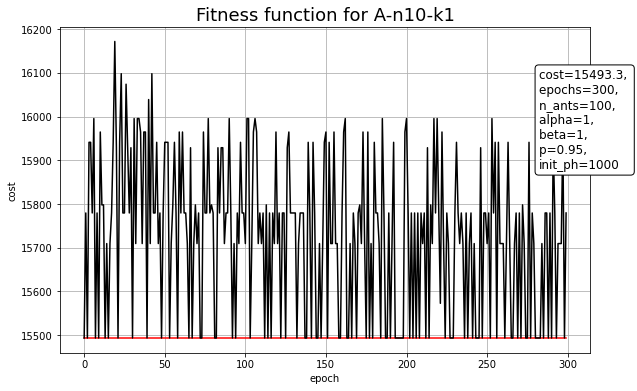

In [78]:
case.plot_function()

In [79]:
import folium

#m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)


depot_longitude       =  -79.383292
depot_latitude        =  43.652224
customer_count        =  10

#coords_long_lat       = np.random.randint(low=[latitude_min, latitude_max], high=[longitude_max, latitude_max], size=(number_cities, 2))

demand = np.random.randint(1, 11, customer_count-1)
demand = np.insert(demand,0,0)
print(demand)

df_map = pd.DataFrame({"longitude":np.random.normal(depot_longitude, 0.008, customer_count),
                       "latitude":np.random.normal(depot_latitude, 0.008, customer_count),
                       "demand":demand})


print(df_map)

[0 2 5 7 6 8 5 4 9 9]
   longitude   latitude  demand
0 -79.385545  43.642796       0
1 -79.387691  43.657930       2
2 -79.381684  43.631499       5
3 -79.393137  43.644775       7
4 -79.392834  43.648769       6
5 -79.392018  43.642295       8
6 -79.375594  43.648000       5
7 -79.373396  43.653228       4
8 -79.390679  43.658506       9
9 -79.392672  43.656887       9


In [203]:
m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)
m
for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == 0:
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

In [204]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0


for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        test5465['longitude']

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=15,
                opacity=0.8).add_to(m)
    i += 1

m